In [1]:
import collections

import numpy as np

import scores
import utils
import model
import torch
import tensorflow as tf
from dataloader import SupervisedDataset
from torch.utils.data import DataLoader
from hyperparam_scheduling import DPScheduler, LRScheduler
import torch.nn.functional as F
import os

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
tf.config.set_visible_devices([], 'GPU')

# for turning off annoying warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

##############################################################################
########################### ADDED CONFIGURATION ##############################
##############################################################################
# Neuromodulation config
LSTM_TYPE = 'Simple_NM'  # default, Simple_NM

RAND_INIT_NOISE = False

# Dropout Scheduling config
DP_SCHEDULING = True
DP_LOWERB = 0.2
DP_UPPERB = 0.8
DP_INIT = 0.5
DP_UPDATE_FREQ = 10  # in epochs

# Learning rate scheduling
LR_SCHEDULING = True
LR_MAX = 1e-5
LR_MIN = LR_MAX*1e-1
LR_UPDATE_FREQ = 10

############################################################################
############################### BASE CONFIG ################################
############################################################################
N_EPOCHS = 1000
RESULT_PER_EPOCH = 10 * 1
CHECKPOINT_PER_EPOCH = 5
EVAL_STEPS = 400 # Original 400
############################################################################
CHECKPOINT_PATH = 'checkpoints/'
############################################################################

NH_LSTM = 128
NH_BOTTLENECK = 256

ENV_SIZE = 2.2
BATCH_SIZE = 10  # original 10
TRAINING_STEPS_PER_EPOCH = 1000    # original 1000
GRAD_CLIPPING = 1e-5  # original 1e-5
SEED = 9101
N_PC = [256]
N_HDC = [12]
BOTTLENECK_DROPOUT = [0.5]
WEIGHT_DECAY = 1e-5
LR = 1e-5  # Original 1e-5
MOMENTUM = 0.9  # Original 0.9
TIME = 50
PAUSE_TIME = None
SAVE_LOC = 'experiments/'

# TRAIN_DATA_RANGE = [0, 3]
# TEST_DATA_RANGE = [3, 6]
TRAIN_DATA_RANGE = [0, 90]
TEST_DATA_RANGE = [90, 100]

scores_filename = 'rates_'
scores_directory = 'results/scores/'
base_trace_filename = 'traces_'
trace_directory = 'results/traces/'

# path = 'data/tmp/'
path = 'data/'
DatasetInfo = collections.namedtuple(
    'DatasetInfo', ['basepath', 'size', 'sequence_length', 'coord_range'])

_DATASETS = dict(
    square_room=DatasetInfo(
        basepath='square_room_100steps_2.2m_1000000',
        size=100,
        sequence_length=100,
        coord_range=((-1.1, 1.1), (-1.1, 1.1))), )

ds_info = _DATASETS['square_room']

feature_map = {
    'init_pos':
        tf.io.FixedLenFeature(shape=[2], dtype=tf.float32),
    'init_hd':
        tf.io.FixedLenFeature(shape=[1], dtype=tf.float32),
    'ego_vel':
        tf.io.FixedLenFeature(
            shape=[ds_info.sequence_length, 3],
            dtype=tf.float32),
    'target_pos':
        tf.io.FixedLenFeature(
            shape=[ds_info.sequence_length, 2],
            dtype=tf.float32),
    'target_hd':
        tf.io.FixedLenFeature(
            shape=[ds_info.sequence_length, 1],
            dtype=tf.float32),
}

data_params = {
    'batch_size': 1000,
    'shuffle': True,
    'num_workers': 2}
test_params = {
    'batch_size': 4096,
    'shuffle': True,
    'num_workers': 2}

# For storing losses
epoch_losses = []
test_losses = []
epoch_hd_losses = []
epoch_pc_losses = []
scheduled_dropouts = []

2022-04-21 07:03:01.766673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 07:03:01.771816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 07:03:01.773322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Equivalent of tf.nn.softmax_crossentropy_with_logits
def Loss_Function(logits, labels):
    logits = F.log_softmax(logits, dim=-1)
    return -(labels*logits).sum(dim=-1)


def softmax_crossentropy_with_logits(labels, logits):
    logits= torch.swapaxes(logits, 0, 1)
    # print('labels', labels.size(), labels[(labels!=0)&(labels!=1)].size())
    # print('logits', logits.size())
    # if labels.size()[2] == 12:
    #     print(labels[0,0,:])
    labels_2d = labels.reshape((-1, labels.size()[2]))
    logits_2d = logits.reshape((-1, logits.size()[2]))
    return Loss_Function(logits_2d, labels_2d)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print('Using device:', device)

Using device: cuda:0


In [20]:
train_data_dic = utils.load_datadic_from_tfrecords(path, _DATASETS, 'square_room', feature_map, TRAIN_DATA_RANGE)
test_data_dic = utils.load_datadic_from_tfrecords(path, _DATASETS, 'square_room', feature_map, TEST_DATA_RANGE)

# Dataset and Dataloader
train_dataset = SupervisedDataset(train_data_dic)
train_dataloader = DataLoader(train_dataset, **data_params)

test_dataset = SupervisedDataset(test_data_dic)
test_dataloader = DataLoader(test_dataset, **test_params)

In [7]:
# Getting place and head direction cell ensembles
place_cell_ensembles = utils.get_place_cell_ensembles(
    env_size=ENV_SIZE,
    neurons_seed=SEED,
    targets_type='softmax',
    lstm_init_type='softmax',
    n_pc=N_PC,
    pc_scale=[0.01],
    device=device)

head_direction_ensembles = utils.get_head_direction_ensembles(
    neurons_seed=SEED,
    targets_type='softmax',
    lstm_init_type='softmax',
    n_hdc=N_HDC,
    hdc_concentration=[20.],
    device=device)

target_ensembles = place_cell_ensembles + head_direction_ensembles

In [8]:
starts = [0.2] * 10
ends = (np.linspace(0.4, 1.0, num=10)).tolist()
masks_parameters = zip(starts, ends)

latest_epoch_scorer = scores.GridScorer(20, _DATASETS['square_room'].coord_range,
                                        masks_parameters)

In [9]:
def run_evaluation(gridtorchmodel):
    gridtorchmodel.eval()
    results = dict()
    
    losses = []
    activations = []
    target_posxy = []
    pred_posxy = []

    with torch.no_grad():
        for X, y in test_dataloader:
            init_pos, init_hd, ego_vel = X
            target_pos, target_hd = y

            init_pos = init_pos.to(device)
            init_hd = init_hd.to(device)
            ego_vel = torch.swapaxes(ego_vel.to(device), 0, 1)

            target_pos = target_pos.to(device)
            target_hd = target_hd.to(device)

            # Getting initial conditions
            init_conds = utils.encode_initial_conditions(init_pos, init_hd, place_cell_ensembles,
                                                         head_direction_ensembles)
            # Getting ensemble targets
            ensemble_targets = utils.encode_targets(target_pos, target_hd, place_cell_ensembles,
                                                    head_direction_ensembles)
            # Initial Hebbian Trace
            if LSTM_TYPE == 'Simple_NM':
                hebb = torch.zeros((init_pos.shape[0], NH_LSTM, NH_LSTM), device=device)
            else:
                hebb = None
            # Running through the model
            outs = gridtorchmodel(ego_vel, init_conds, hebb)

            # Collecting different parts of the output
            logits_hd, logits_pc, bottleneck_acts, rnn_states, rnn_cells = outs

            # Computing test loss
            pc_loss = softmax_crossentropy_with_logits(labels=ensemble_targets[0], logits=logits_pc)
            hd_loss = softmax_crossentropy_with_logits(labels=ensemble_targets[1], logits=logits_hd)

            total_loss = pc_loss + hd_loss
            test_loss = total_loss.mean()

            # weight decay
            test_loss += gridtorchmodel.l2_loss * WEIGHT_DECAY

            losses.append(test_loss.clone().item())

            # accumulating for plotting
            # activations.append(torch.swapaxes(bottleneck_acts.detach(), 0, 1))
            target_posxy.append(target_pos.detach().cpu().numpy())
            pred_posxy.append(np.swapaxes(logits_pc.detach().cpu().numpy(), 0, 1))
            # break
    
    
    losses = np.array(losses)
    test_loss_mean = losses.mean()
    test_loss_std = losses.std()
    
    # activations = torch.cat(activations).cpu().numpy()
    target_posxy = np.concatenate(target_posxy)
    pred_posxy = np.concatenate(pred_posxy)
    
    err_amb_mean, err_amb_std = utils.get_spatial_error(target_posxy, pred_posxy, place_cell_ensembles[0].means.cpu().numpy())
    
    results['test_loss_mean'] = test_loss_mean
    results['test_loss_std'] = test_loss_std
    results['err_amb_mean'] = err_amb_mean
    results['err_amb_std'] = err_amb_std
    

    losses = []
    target_posxy = []
    pred_posxy = []
    step = 1
    train_steps_epoch = 10

    with torch.no_grad():
        for X, y in train_dataloader:
            init_pos, init_hd, ego_vel = X
            target_pos, target_hd = y

            init_pos = init_pos.to(device)
            init_hd = init_hd.to(device)
            ego_vel = torch.swapaxes(ego_vel.to(device), 0, 1)

            target_pos = target_pos.to(device)
            target_hd = target_hd.to(device)

            # Getting initial conditions
            init_conds = utils.encode_initial_conditions(init_pos, init_hd, place_cell_ensembles,
                                                         head_direction_ensembles)
            # Getting ensemble targets
            ensemble_targets = utils.encode_targets(target_pos, target_hd, place_cell_ensembles,
                                                    head_direction_ensembles)
            # Initial Hebbian Trace
            if LSTM_TYPE == 'Simple_NM':
                hebb = torch.zeros((init_pos.shape[0], NH_LSTM, NH_LSTM), device=device)
            else:
                hebb = None
            # Running through the model
            outs = gridtorchmodel(ego_vel, init_conds, hebb)

            # Collecting different parts of the output
            logits_hd, logits_pc, bottleneck_acts, rnn_states, rnn_cells = outs

            # Computing test loss
            pc_loss = softmax_crossentropy_with_logits(labels=ensemble_targets[0], logits=logits_pc)
            hd_loss = softmax_crossentropy_with_logits(labels=ensemble_targets[1], logits=logits_hd)

            total_loss = pc_loss + hd_loss
            train_loss = total_loss.mean()

            # weight decay
            train_loss += gridtorchmodel.l2_loss * WEIGHT_DECAY

            losses.append(train_loss.clone().item())
            
            if step >= train_steps_epoch:
                break
            step += 1
    losses = np.array(losses)
    train_loss_mean = losses.mean()
    train_loss_std = losses.std()

    results['train_loss_mean'] = train_loss_mean
    results['train_loss_std'] = train_loss_std
    
    return results

In [48]:
def get_grid_score_dist(model_name, LSTM_TYPE):
    gridtorchmodel = model.GridTorch(target_ensembles, NH_LSTM, NH_BOTTLENECK,
                                     dropoutrates_bottleneck=BOTTLENECK_DROPOUT,
                                     LSTM_type=LSTM_TYPE).to(device)
    params = gridtorchmodel.parameters()

    # Optimizer
    optimizer = torch.optim.RMSprop(params,
                                    lr=LR,
                                    momentum=MOMENTUM,
                                    alpha=0.9,
                                    eps=1e-10)
    
    checkpoint = torch.load(CHECKPOINT_PATH + f'{model_name}.pt')
    # start_epoch = checkpoint['epoch'] + 1
    gridtorchmodel.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # epoch_losses = checkpoint['epoch_losses']
    # test_losses = checkpoint['test_losses']
    # epoch_pc_losses = checkpoint['epoch_pc_losses']
    # epoch_hd_losses = checkpoint['epoch_hd_losses']
    # scheduled_dropouts = np.load('dropouts.npy').tolist()
    # print(f'loaded current dp {scheduled_dropouts[-1]}')
    # dp_scheduler.current_dp = scheduled_dropouts[-1]
    
    losses, activations, target_posxy, pred_posxy = run_evaluation(gridtorchmodel, optimizer)
    
    activations_np = torch.cat(activations).cpu().numpy()
    target_posxy_np = torch.cat(target_posxy).cpu().numpy()
    pred_posxy_np = torch.cat(pred_posxy).cpu().numpy()

    results_filename = None
    scores = utils.get_scores_and_plot(latest_epoch_scorer, target_posxy_np, activations_np, scores_directory, results_filename, plot_graphs=False)[0]
    return scores

In [49]:
models = [('base-dp2', 'default'),
          ('base-dp3', 'default'),
          ('base-dp5', 'default'),
          ('base-dp7', 'default'),
          ('base-dp2', 'default'),
          ('base-noisyinit', 'default'),
          ('base-SGD', 'defualt'),
          ('base-strict-GC', 'default'),
          ('base-strict-LR-GC', 'default'),
          ('base-strict-LR', 'default'),
          ('NM', 'Simple_NM'),
          ('NM-Ada-dp', 'Simple_NM'),
         ]

In [50]:
dists = {}
for model_type, lstm_type in models:
    print(model_type)
    dists[model_type] = get_grid_score_dist(model_type, lstm_type)

base-dp2


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/base-dp2.pt'

In [51]:
dist = get_grid_score_dist('base-dp5', 'defualt')

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/base-dp5.pt'

Text(0.5, 8.960000000000022, 'grid score')

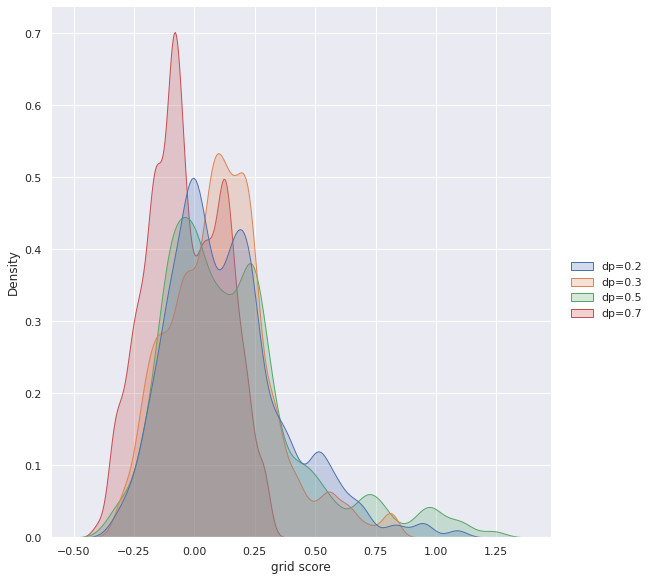

In [51]:
cmp_dp = {}
cmp_dp['dp=0.2'] = dists['base-dp2']
cmp_dp['dp=0.3'] = dists['base-dp3']
cmp_dp['dp=0.5'] = dists['base-dp5']
cmp_dp['dp=0.7'] = dists['base-dp7']
fig = sns.displot(cmp_dp, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('grid score')

## Effect of Neuromodulation

Text(0.5, 8.960000000000022, 'grid score')

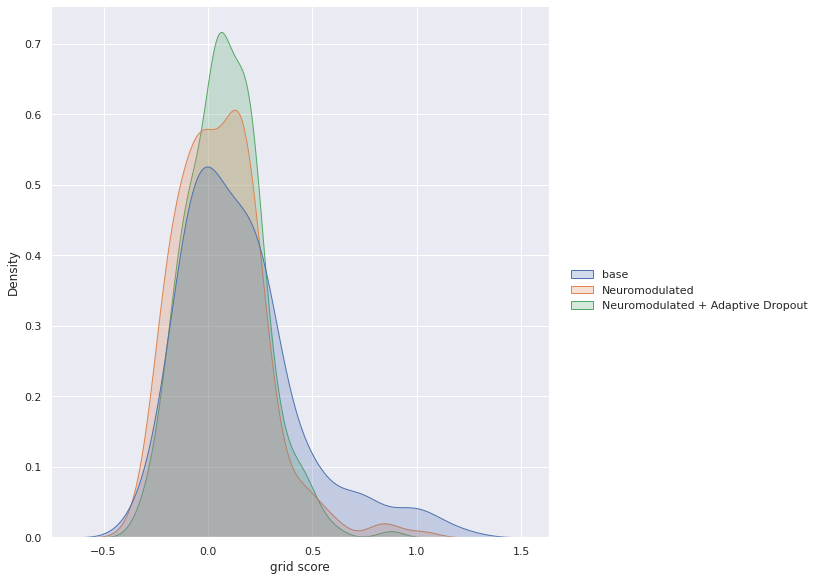

In [58]:
cmp_dp = {}
cmp_dp['base'] = dists['base-dp5']
cmp_dp['Neuromodulated'] = dists['NM']
cmp_dp['Neuromodulated + Adaptive Dropout'] = dists['NM-Ada-dp']
fig = sns.displot(cmp_dp, kind='kde', bw_adjust=1, fill=True, height=8)
plt.xlabel('grid score')

## effect of optimizer

Text(0.5, 8.960000000000022, 'grid score')

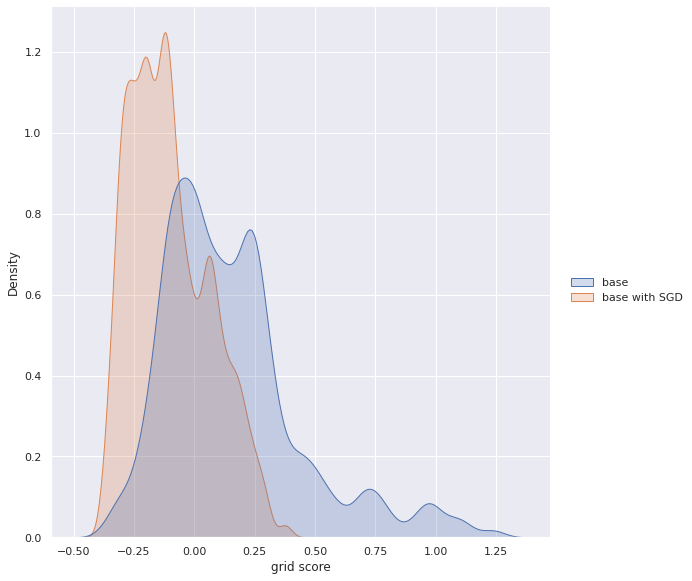

In [59]:
cmp_dp = {}
cmp_dp['base'] = dists['base-dp5']
cmp_dp['base with SGD'] = dists['base-SGD']
fig = sns.displot(cmp_dp, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('grid score')

## Effect of Learning Rate

Text(0.5, 8.960000000000022, 'grid score')

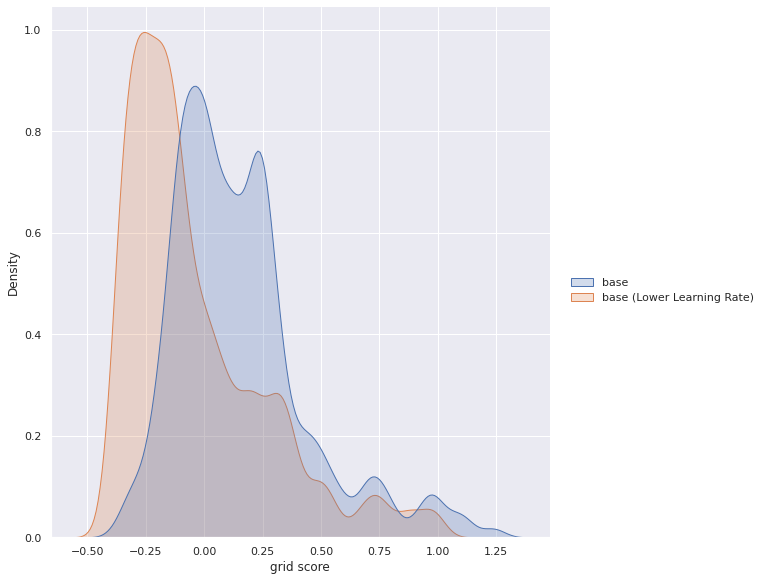

In [60]:
cmp_dp = {}
cmp_dp['base'] = dists['base-dp5']
cmp_dp['base (Lower Learning Rate)'] = dists['base-strict-LR']
fig = sns.displot(cmp_dp, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('grid score')

## Effect of Gradient Clipping

Text(0.5, 8.960000000000022, 'grid score')

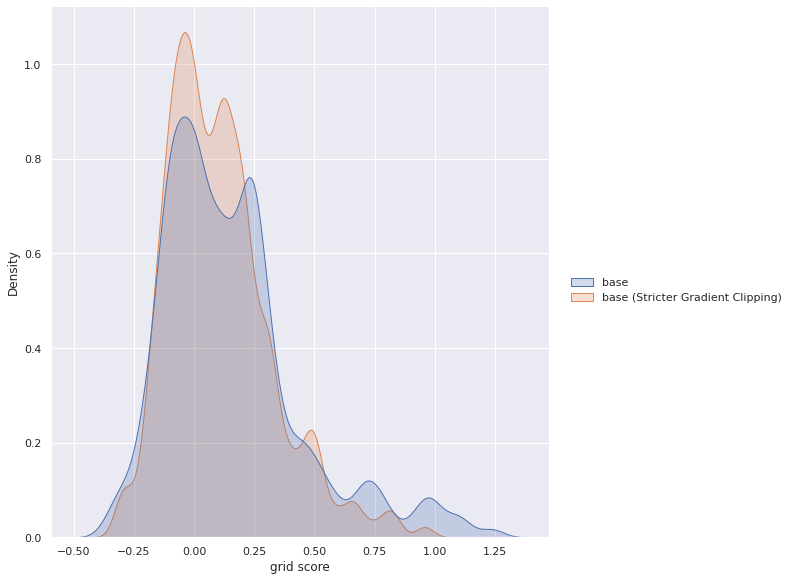

In [62]:
cmp_dp = {}
cmp_dp['base'] = dists['base-dp5']
cmp_dp['base (Stricter Gradient Clipping)'] = dists['base-strict-GC']
fig = sns.displot(cmp_dp, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('grid score')

## Effect of Both Learning Rate and Gradient Clipping

Text(0.5, 8.960000000000022, 'grid score')

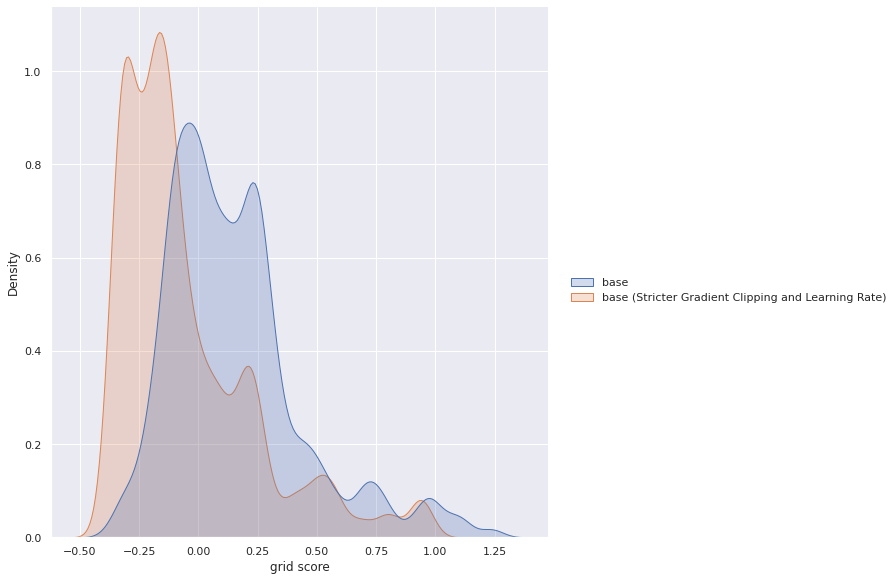

In [68]:
cmp_dp = {}
cmp_dp['base'] = dists['base-dp5']
cmp_dp['base (Stricter Gradient Clipping and Learning Rate)'] = dists['base-strict-LR-GC']
fig = sns.displot(cmp_dp, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('grid score')

## Effect of noisy intial input

Text(0.5, 8.960000000000022, 'grid score')

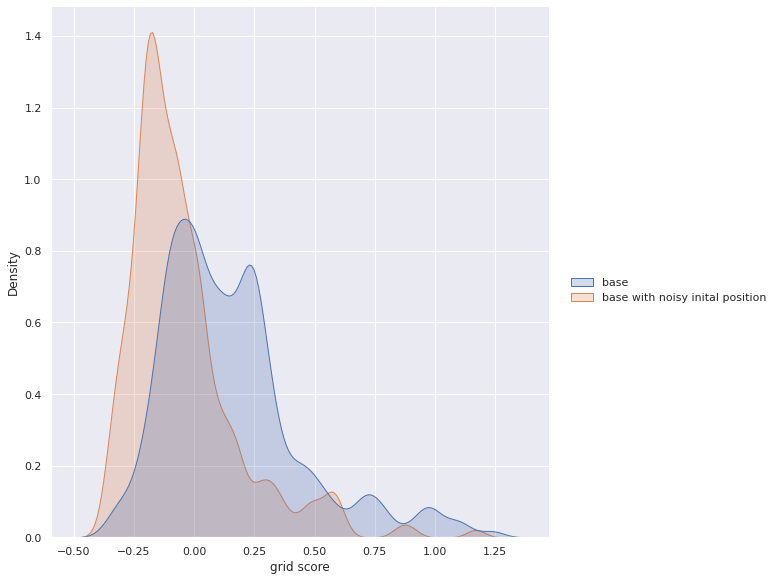

In [65]:
cmp_dp = {}
cmp_dp['base'] = dists['base-dp5']
cmp_dp['base with noisy inital position'] = dists['base-noisyinit']
fig = sns.displot(cmp_dp, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('grid score')

In [ ]:
def log_evaluations(losses, activations, target_posxy, pred_posxy):
    losses_t = torch.tensor(losses)
    test_loss_mean = losses_t.mean()
    test_loss_std = losses_t.std()
    test_losses.append(test_loss_mean)
    print(f'Mean test loss: {test_loss_mean:4.4f}  Test loss std: {test_loss_std:4.4f}')

    activations_np = torch.cat(activations).cpu().numpy()
    target_posxy_np = torch.cat(target_posxy).cpu().numpy()
    pred_posxy_np = torch.cat(pred_posxy).cpu().numpy()

    results_filename = scores_filename + f'{epoch:04d}.pdf'
    trace_filename = base_trace_filename + f'{epoch:04d}.pdf'
    utils.get_scores_and_plot(latest_epoch_scorer, target_posxy_np, activations_np, scores_directory, results_filename)
    utils.get_traces_and_plot(target_posxy_np, pred_posxy_np, place_cell_ensembles[0].means.cpu().numpy(), trace_directory,
                              trace_filename)


## Getting grid score distributions

In [10]:
def get_gridscore_dist(gridtorchmodel):
    gridtorchmodel.eval()
    results = dict()
    
    losses = []
    activations = []
    target_posxy = []
    pred_posxy = []

    with torch.no_grad():
        for X, y in test_dataloader:
            init_pos, init_hd, ego_vel = X
            target_pos, target_hd = y

            init_pos = init_pos.to(device)
            init_hd = init_hd.to(device)
            ego_vel = torch.swapaxes(ego_vel.to(device), 0, 1)

            target_pos = target_pos.to(device)
            target_hd = target_hd.to(device)

            # Getting initial conditions
            init_conds = utils.encode_initial_conditions(init_pos, init_hd, place_cell_ensembles,
                                                         head_direction_ensembles)
            # Getting ensemble targets
            ensemble_targets = utils.encode_targets(target_pos, target_hd, place_cell_ensembles,
                                                    head_direction_ensembles)
            # Initial Hebbian Trace
            if LSTM_TYPE == 'Simple_NM':
                hebb = torch.zeros((init_pos.shape[0], NH_LSTM, NH_LSTM), device=device)
            else:
                hebb = None
            # Running through the model
            outs = gridtorchmodel(ego_vel, init_conds, hebb)

            # Collecting different parts of the output
            logits_hd, logits_pc, bottleneck_acts, rnn_states, rnn_cells = outs

            # accumulating for plotting
            activations.append(np.swapaxes(bottleneck_acts.detach().cpu().numpy(), 0, 1))
            target_posxy.append(target_pos.detach().cpu().numpy())
            # pred_posxy.append(np.swapaxes(logits_pc.detach().cpu().numpy(), 0, 1))
            # break
    
    activations = np.concatenate(activations)
    target_posxy = np.concatenate(target_posxy)
    # pred_posxy = np.concatenate(pred_posxy)
    
    # err_amb_mean, err_amb_std = utils.get_spatial_error(target_posxy, pred_posxy, place_cell_ensembles[0].means.cpu().numpy())
    score_60, score_90, s, sac = utils.get_scores(latest_epoch_scorer, target_posxy, activations)
    
    results['score_60'] = score_60
    results['score_90'] = score_90
    results['ratemap'] = np.array(s)
    results['autocorrelation'] = np.array(sac)
    return results
    

## Getting pred and true positions

In [11]:
def get_pred_pos(gridtorchmodel, X, y):
    gridtorchmodel.eval()
    results = dict()
    
    losses = []
    activations = []
    target_posxy = []
    pred_posxy = []

    with torch.no_grad():
        init_pos, init_hd, ego_vel = X
        target_pos, target_hd = y

        init_pos = init_pos.to(device)
        init_hd = init_hd.to(device)
        ego_vel = torch.swapaxes(ego_vel.to(device), 0, 1)

        target_pos = target_pos.to(device)
        target_hd = target_hd.to(device)

        # Getting initial conditions
        init_conds = utils.encode_initial_conditions(init_pos, init_hd, place_cell_ensembles,
                                                     head_direction_ensembles)
        # Getting ensemble targets
        ensemble_targets = utils.encode_targets(target_pos, target_hd, place_cell_ensembles,
                                                head_direction_ensembles)
        # Initial Hebbian Trace
        if LSTM_TYPE == 'Simple_NM':
            hebb = torch.zeros((init_pos.shape[0], NH_LSTM, NH_LSTM), device=device)
        else:
            hebb = None
        # Running through the model
        outs = gridtorchmodel(ego_vel, init_conds, hebb)

        # Collecting different parts of the output
        logits_hd, logits_pc, bottleneck_acts, rnn_states, rnn_cells = outs

        # accumulating for plotting
        # activations.append(np.swapaxes(bottleneck_acts.detach().cpu().numpy(), 0, 1))
        target_posxy.append(target_pos.detach().cpu().numpy())
        pred_posxy.append(np.swapaxes(logits_pc.detach().cpu().numpy(), 0, 1))

    
    # activations = np.concatenate(activations)
    target_posxy = np.concatenate(target_posxy)
    pred_posxy = np.concatenate(pred_posxy)
    
    # err_amb_mean, err_amb_std = utils.get_spatial_error(target_posxy, pred_posxy, place_cell_ensembles[0].means.cpu().numpy())
    # score_60, score_90, s, sac = utils.get_scores(latest_epoch_scorer, target_posxy, activations)
    targets, preds = utils.get_all_traces(target_posxy, pred_posxy, place_cell_ensembles[0].means.cpu().numpy())
    
    results['targets'] = targets
    results['preds'] = preds
    return results
    

# Running to get needed stats

In [12]:
def get_result_stats(run_name, model_no, LSTM_TYPE, mode='gridscore', sampleX=None, sampleY=None):
    gridtorchmodel = model.GridTorch(target_ensembles, NH_LSTM, NH_BOTTLENECK,
                                     dropoutrates_bottleneck=BOTTLENECK_DROPOUT,
                                     LSTM_type=LSTM_TYPE).eval().to(device)
    # params = gridtorchmodel.parameters()

    # Optimizer
    # optimizer = torch.optim.RMSprop(params,
                                    # lr=LR,
                                    # momentum=MOMENTUM,
                                    # alpha=0.9,
                                    # eps=1e-10)
    
    checkpoint = torch.load(CHECKPOINT_PATH + f'{run_name}/model_{model_no:04d}.pt')
    # start_epoch = checkpoint['epoch'] + 1
    gridtorchmodel.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # epoch_losses = checkpoint['epoch_losses']
    # test_losses = checkpoint['test_losses']
    # epoch_pc_losses = checkpoint['epoch_pc_losses']
    # epoch_hd_losses = checkpoint['epoch_hd_losses']
    # scheduled_dropouts = np.load('dropouts.npy').tolist()
    # print(f'loaded current dp {scheduled_dropouts[-1]}')
    # dp_scheduler.current_dp = scheduled_dropouts[-1]
    
    if mode == 'gridscore':
        results = get_gridscore_dist(gridtorchmodel)
    elif mode == 'trace':
        results = get_pred_pos(gridtorchmodel, sampleX, sampleY)
    else:
        results = run_evaluation(gridtorchmodel)
    
    return results

In [13]:
results_dir = 'results/stats/'

In [14]:
def eval_all_checkpoints(run_name, LSTM_TYPE):
    run_results_dir = f'{results_dir}{run_name}-'
    # if not os.path.exists(run_results_dir):
    #     os.makedirs(run_results_dir, exist_ok=True)

    model_nos = [i for i in range(0, 1000, 5)]
    train_loss_means = []
    train_loss_stds = []
    test_loss_means = []
    test_loss_stds = []
    err_amb_means = []
    err_amb_stds = []
    
    for model_no in tqdm(model_nos):
        results = get_result_stats(run_name, model_no, LSTM_TYPE, 'loss')
        train_loss_means.append(results['train_loss_mean'])
        train_loss_stds.append(results['train_loss_std'])
        test_loss_means.append(results['test_loss_mean'])
        test_loss_stds.append(results['test_loss_std'])
        err_amb_means.append(results['err_amb_mean'])
        err_amb_stds.append(results['err_amb_std'])
    
    train_loss_means = np.array(train_loss_means)
    train_loss_stds = np.array(train_loss_stds)
    test_loss_means = np.array(test_loss_means)
    test_loss_stds = np.array(test_loss_stds)
    err_amb_means = np.array(err_amb_means)
    arr_amb_stds = np.array(err_amb_stds)
    
    np.save(run_results_dir+'train_loss_means'+'.npy', train_loss_means)
    np.save(run_results_dir+'train_loss_stds'+'.npy', train_loss_stds)
    np.save(run_results_dir+'test_loss_means'+'.npy', test_loss_means)
    np.save(run_results_dir+'test_loss_stds'+'.npy', test_loss_stds)
    np.save(run_results_dir+'err_amb_means'+'.npy', err_amb_means)
    np.save(run_results_dir+'err_amb_stds'+'.npy', err_amb_stds)

In [15]:
def get_checkpoint_gridscore_dist(run_name, LSTM_TYPE):
    run_results_dir = f'{results_dir}{run_name}-'
    # if not os.path.exists(run_results_dir):
    #     os.makedirs(run_results_dir, exist_ok=True)

    model_nos = [0, 5, 10, 20, 40, 60, 100, 200, 300, 400, 500, 600, 700, 800, 900, 995]
    score_dist_60 = []
    score_dist_90 = []
    ratemaps = []
    acs = []
    
    for model_no in tqdm(model_nos):
        results = get_result_stats(run_name, model_no, LSTM_TYPE, 'gridscore')
        score_dist_60.append(results['score_60'])
        score_dist_90.append(results['score_90'])
        ratemaps.append(results['ratemap'])
        acs.append(results['autocorrelation'])
    
    score_dist_60 = np.array(score_dist_60)
    score_dist_90 = np.array(score_dist_90)
    ratemaps = np.stack(ratemaps)
    acs = np.stack(acs)
    
    np.save(run_results_dir+'score_dist_60'+'.npy', score_dist_60)
    np.save(run_results_dir+'score_dist_90'+'.npy', score_dist_90)
    np.save(run_results_dir+'ratemaps'+'.npy', ratemaps)
    np.save(run_results_dir+'autocorrelations'+'.npy', acs)

In [16]:
def get_checkpoint_trace_sample(run_name, LSTM_TYPE):
    run_results_dir = f'{results_dir}{run_name}-'
    # if not os.path.exists(run_results_dir):
    #     os.makedirs(run_results_dir, exist_ok=True)

    model_nos = [0, 5, 10, 20, 40, 60, 100, 200, 300, 400, 500, 600, 700, 800, 900, 995]
    pred_pos = []
    true_pos = []
    
    sampleX, sampleY = next(iter(test_dataloader))
    
    for model_no in tqdm(model_nos):
        results = get_result_stats(run_name, model_no, LSTM_TYPE, 'trace', sampleX, sampleY)
        pred_pos.append(results['preds'])
        true_pos.append(results['targets'])
        
    pred_pos = np.stack(pred_pos)
    true_pos = np.stack(true_pos)
    
    np.save(run_results_dir+'pred_pos'+'.npy', pred_pos)
    np.save(run_results_dir+'true_pos'+'.npy', true_pos)

In [ ]:
# runs = [['run1', 'default'],
#         ['run5', 'default'],
#         ['run19', 'default'],
#         ['run20', 'default'],
#         ['run2', 'Simple_NM'],
#         ['run6', 'Simple_NM'],
#         ['run26', 'Simple_NM'],
#         ['run22', 'Simple_NM'],
#         ['run23', 'Simple_NM'],
#         ['run27', 'Simple_NM'],
#         ['run24', 'Simple_NM'],
#         ['run25', 'Simple_NM'],
#         ['run28', 'Simple_NM']]
runs = [
    ['run29', 'Simple_NM'],
    ['run32', 'Simple_NM'],
    ['run33', 'Simple_NM']]

for run in runs:
    print(run[0])
    eval_all_checkpoints(*run)
# for run in runs:
#     print(run[0])
    # get_checkpoint_gridscore_dist(*run)
    # get_checkpoint_trace_sample(*run)

run29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:22:22<00:00, 24.71s/it]


run32


 54%|███████████████████████████████████████████████████████████▍                                                  | 108/200 [44:24<37:48, 24.65s/it]

In [ ]:
for run in runs:
    print(run[0])
    get_checkpoint_gridscore_dist(*run)
    # get_checkpoint_trace_sample(*run)

In [ ]:
for run in runs:
    print(run[0])
    # get_checkpoint_gridscore_dist(*run)
    get_checkpoint_trace_sample(*run)

# Loading computed stats for viz

In [29]:
base_runs = ['run1', 'run5', 'run19', 'run20']
nm_runs = ['run2', 'run6', 'run26']
nm_dp_runs = ['run22', 'run23', 'run27']
nm_dp_lr_runs = ['run24', 'run25', 'run28']
nm_dm_lr4_runs = ['run29', 'run32', 'run33']

## Learning Curves

In [24]:
def load_stats(dir_path, run_names, stat_class):
    loss = []
    for run in run_names:
        tmp_loss = np.load(f'{dir_path}/{run}-{stat_class}.npy')
        loss.append(tmp_loss)
    return np.stack(loss)

In [25]:
def load_gridscore_dist(dir_path, run_names):
    scores_60 = []
    scores_90 = []
    for run in run_names:
        score_60 = np.load(f'{dir_path}/{run}-score_dist_60.npy')
        scores_60.append(score_60)
        score_90 = np.load(f'{dir_path}/{run}-score_dist_90.npy')
        scores_90.append(score_90)
    return np.stack(scores_60), np.stack(scores_90)

In [26]:
def load_ratemaps(dir_path, run_names):
    ratemaps = []
    for run in run_names:
        ratemap = np.load(f'{dir_path}/{run}-ratemaps.npy')
        ratemaps.append(ratemap)
    return np.stack(ratemaps)

def load_autocorrelations(dir_path, run_names):
    autocorrelations = []
    for run in run_names:
        ae = np.load(f'{dir_path}/{run}-autocorrelations.npy')
        autocorrelations.append(ae)
    return np.stack(autocorrelations)

In [27]:
def load_traces(dir_path, run_names):
    pred_pos = []
    true_pos = []
    for run in run_names:
        preds = np.load(f'{dir_path}/{run}-pred_pos.npy')
        pred_pos.append(preds)
        targets = np.load(f'{dir_path}/{run}-true_pos.npy')
        true_pos.append(targets)
    return np.stack(pred_pos), np.stack(true_pos)

In [30]:
base_loss = load_stats('results/stats', base_runs, 'train_loss_means')
nm_loss = load_stats('results/stats', nm_runs, 'train_loss_means')
nm_dp_loss = load_stats('results/stats', nm_dp_runs, 'train_loss_means')
nm_dp_lr_loss = load_stats('results/stats', nm_dp_lr_runs, 'train_loss_means')

In [31]:
base_dist_60, base_dist_90 = load_gridscore_dist('results/stats', base_runs)
nm_dist_60, nm_dist_90 = load_gridscore_dist('results/stats', nm_runs)
nm_dp_dist_60, nm_dp_dist_90 = load_gridscore_dist('results/stats', nm_dp_runs)
nm_dp_lr_dist_60, nm_dp_lr_dist_90 = load_gridscore_dist('results/stats', nm_dp_lr_runs)

In [32]:
base_ratemaps = load_ratemaps('results/stats', base_runs)
nm_ratemaps = load_ratemaps('results/stats', nm_runs)
nm_dp_ratemaps = load_ratemaps('results/stats', nm_dp_runs)
nm_dp_lr_ratemaps = load_ratemaps('results/stats', nm_dp_lr_runs)

In [33]:
base_aes = load_autocorrelations('results/stats', base_runs)
nm_aes = load_autocorrelations('results/stats', nm_runs)
nm_dp_aes = load_autocorrelations('results/stats', nm_dp_runs)
nm_dp_lr_aes = load_autocorrelations('results/stats', nm_dp_lr_runs)

In [34]:
base_traces = load_traces('results/stats', base_runs)
nm_traces = load_traces('results/stats', nm_runs)
nm_dp_traces = load_traces('results/stats', nm_dp_runs)
nm_dp_lr_traces = load_traces('results/stats', nm_dp_lr_runs)

In [145]:
base_traces[0].shape

(4, 16, 409600, 2)

## Ratemap Evolution

### Base model

In [55]:
def select_ratemaps_by_idx(ratemaps, idx):
    tmp = []
    for i in range(16):
        tmp.append(base_ratemaps[0, i, idx[0, i]:idx[0, i] + 1, :, :])
    tmp = np.concatenate(tmp, axis=0)
    return tmp

In [106]:
def plot_firing(firings, dist_60, dist_90, model_nos, ratemap=True):
    idx1 = np.argmax(dist_60, axis=2)
    idx2 = np.argmin(abs(dist_60), axis=2)
    idx3 = np.argmin(dist_60, axis=2)
    idx4 = np.argmax(dist_90, axis=2)
    idx5 = np.argmin(abs(dist_90), axis=2)
    idx6 = np.argmin(dist_90, axis=2)
    
    
    f1 = firings[0, :, idx1[0, -1], : ,:]
    f2 = firings[0, :, idx2[0, -1], : ,:]
    f3 = firings[0, :, idx3[0, -1], : ,:]
    f4 = firings[0, :, idx4[0, -1], : ,:]
    f5 = firings[0, :, idx5[0, -1], : ,:]
    f6 = firings[0, :, idx6[0, -1], : ,:]
    
    # ratemap1 = select_ratemaps_by_idx(ratemaps, idx1)
    # ratemap2 = select_ratemaps_by_idx(ratemaps, idx2)
    # ratemap3 = select_ratemaps_by_idx(ratemaps, idx3)
    # ratemap4 = select_ratemaps_by_idx(ratemaps, idx4)
    f_arrays = [f1, f2, f3, f4, f5, f6]
    
    plt.figure()
    fig, axs = plt.subplots(len(f_arrays), firings.shape[1], sharex=True, sharey=True, figsize=(24,14))
    for i in range(len(f_arrays)):
        for j in range(firings.shape[1]):
            f = f_arrays[i][j]
            if ratemap:
                axs[i][j].imshow(f, aspect='equal', cmap='jet')
            else:
                latest_epoch_scorer.plot_sac(f, None, axs[i][j], cmap='jet')
            if i == 0:
                axs[i][j].set_title(f'epoch {model_nos[j]}')
    plt.show()

In [37]:
model_nos = [0, 5, 10, 20, 40, 60, 100, 200, 300, 400, 500, 600, 700, 800, 900, 995]

<Figure size 432x288 with 0 Axes>

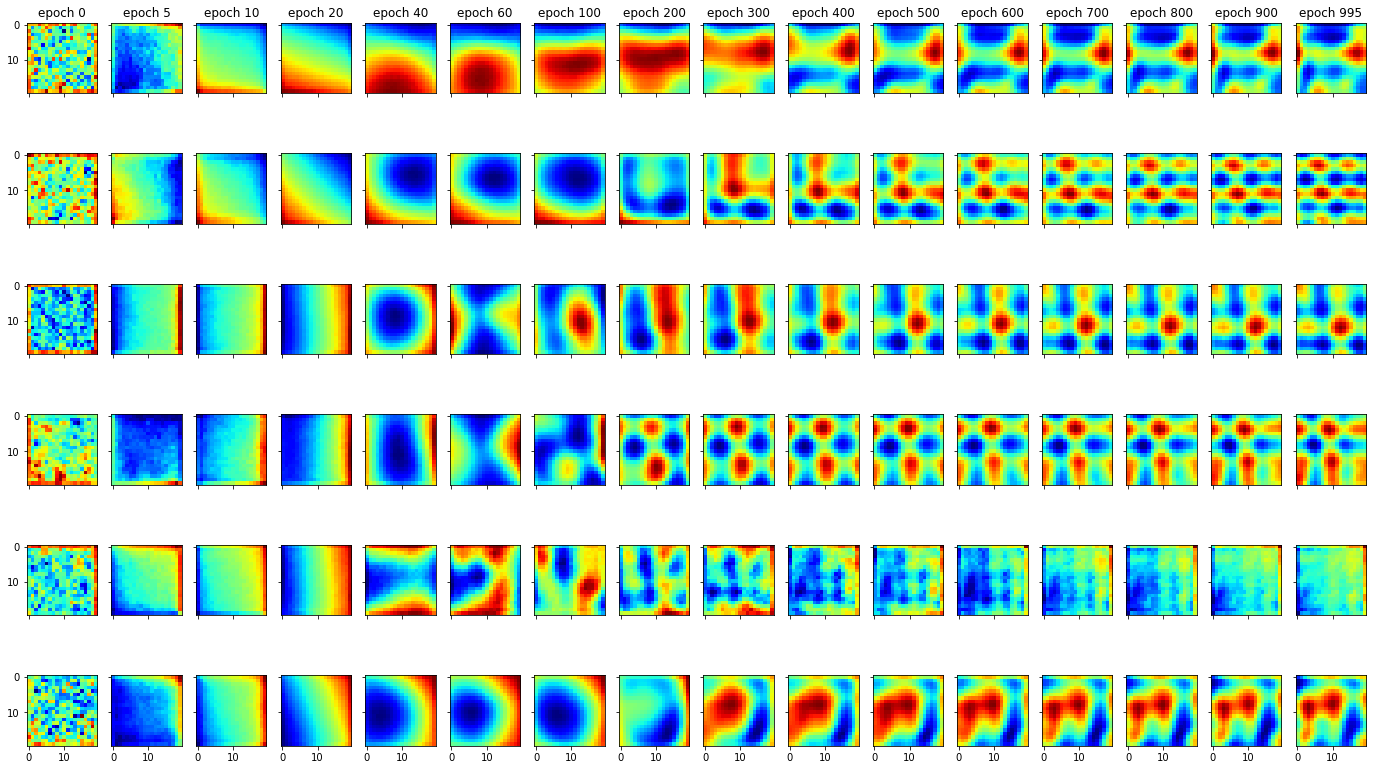

In [109]:
plot_firing(nm_ratemaps, nm_dist_60, nm_dist_90, model_nos, ratemap=True)

## Spatial Autocorrelogram Evolution

<Figure size 432x288 with 0 Axes>

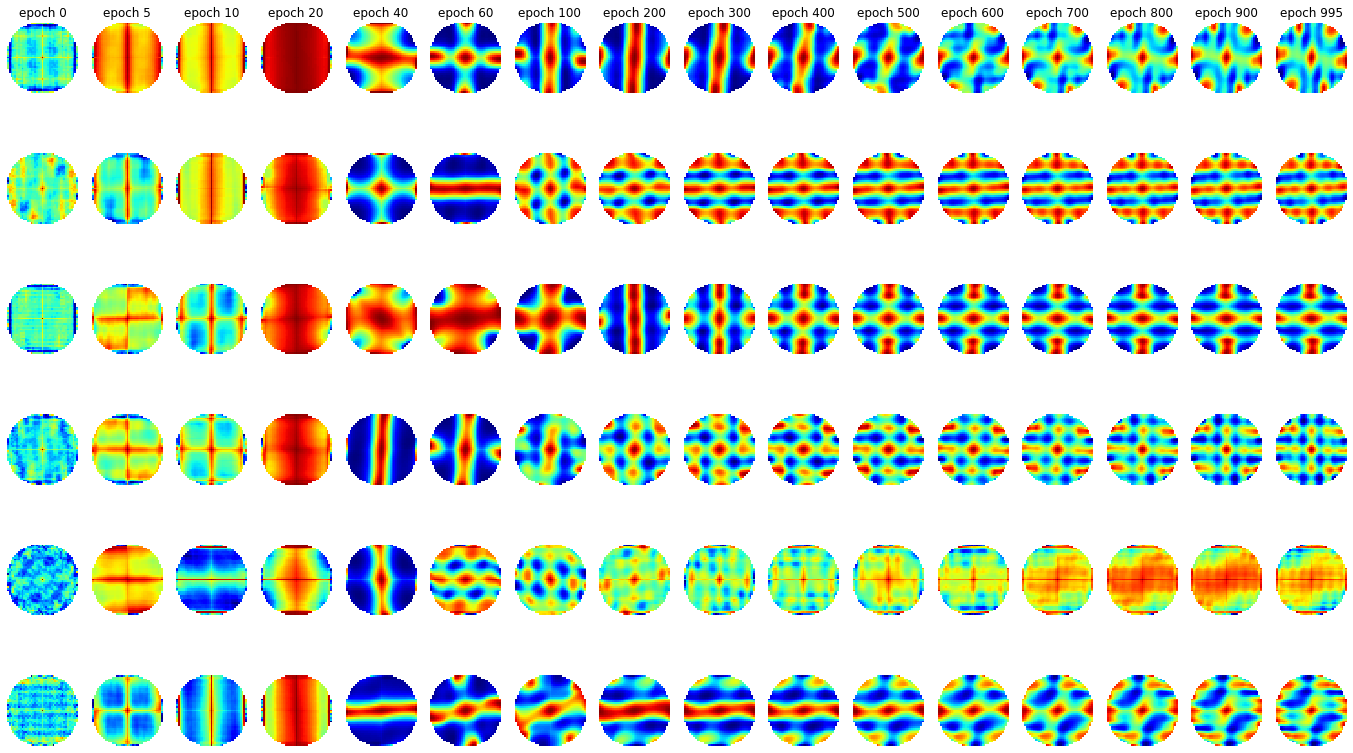

In [110]:
plot_firing(base_aes, base_dist_60, base_dist_90, model_nos, False)

## Score Distribution Evolution

Text(0.5, 6.799999999999997, 'grid score 60')

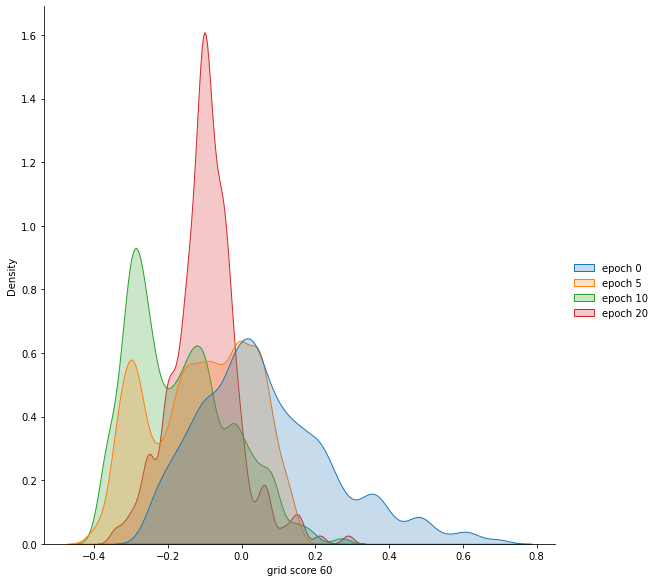

In [51]:
model_nos = [0, 5, 10, 20, 40, 60, 100, 200, 300, 400, 500, 600, 700, 800, 900, 995]
plot_dict = {}
for i in range(4):
    plot_dict[f'epoch {model_nos[i]}'] = base_dist_60[0, i, :]
cig = sns.displot(plot_dict, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('grid score 60')

Text(0.5, 6.799999999999997, 'grid score 90')

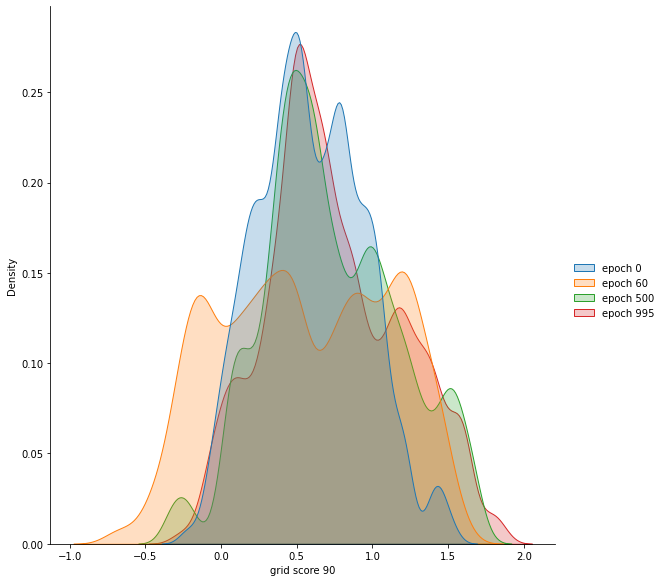

In [40]:
model_nos = [0, 5, 10, 20, 40, 60, 100, 200, 300, 400, 500, 600, 700, 800, 900, 995]
plot_dict = {}
for i in range(0, 16, 5):
    plot_dict[f'epoch {model_nos[i]}'] = base_dist_90[0, i, :]
cig = sns.displot(plot_dict, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('grid score 90')

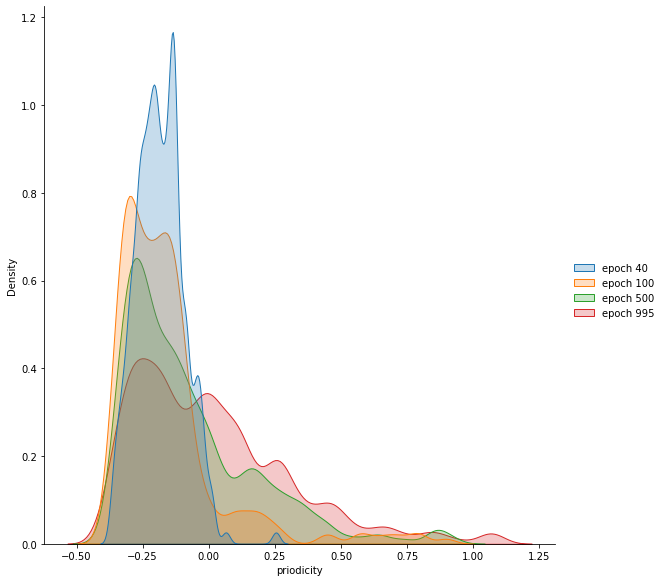

In [36]:
model_nos = [0, 5, 10, 20, 40, 100, 500, 995]
plot_dict = {}
for i in range(4, 8):
    dist = np.concatenate([base_dist_60[0, i, :].reshape(-1, 1), base_dist_60[0, i, :].reshape(-1, 1)], axis=1)
    plot_dict[f'epoch {model_nos[i]}'] = np.max(dist, axis=1)
cig = sns.displot(plot_dict, kind='kde', bw_adjust=0.5, fill=True, height=8)
plt.xlabel('priodicity')
plt.show()

In [42]:
x = np.linspace(0, 995, 200)

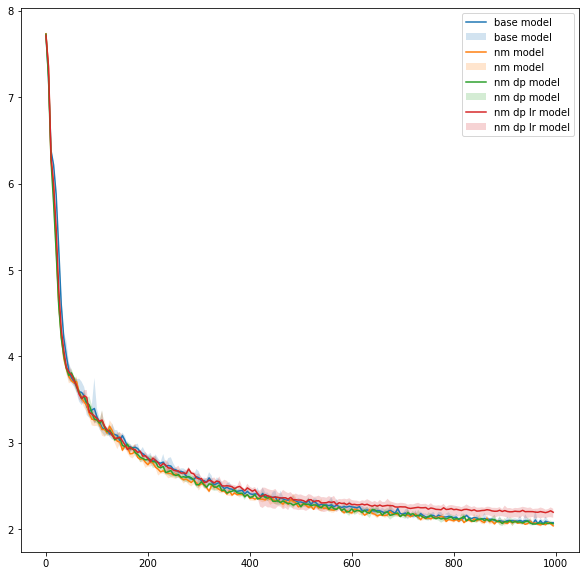

In [48]:
plt.figure(figsize=(10,10))
start=0
plt.plot(x[start:], base_loss.mean(axis=0)[start:], '-', label='base model')
plt.fill_between(x, base_loss.min(axis=0), base_loss.max(axis=0), label='base model', alpha=0.2)
plt.plot(x[start:], nm_loss.mean(axis=0)[start:], '-', label='nm model')
plt.fill_between(x, nm_loss.min(axis=0), nm_loss.max(axis=0), label='nm model', alpha=0.2)
plt.plot(x[start:], nm_dp_loss.mean(axis=0)[start:], '-', label='nm dp model')
plt.fill_between(x, nm_dp_loss.min(axis=0), nm_dp_loss.max(axis=0), label='nm dp model', alpha=0.2)
plt.plot(x[start:], nm_dp_lr_loss.mean(axis=0)[start:], '-', label='nm dp lr model')
plt.fill_between(x, nm_dp_lr_loss.min(axis=0), nm_dp_lr_loss.max(axis=0), label='nm dp lr model', alpha=0.2)
plt.legend()
plt.show()

## Trace Evolution

In [56]:
def plot_traces(traces, model_nos, no_samples=4):
    preds, targets = traces
    sample = np.random.randint(0, 4096, no_samples)
    preds = preds.reshape(preds.shape[0], preds.shape[1], 4096, 100, 2)
    targets = targets.reshape(targets.shape[0], targets.shape[1], 4096, 100, 2)
    sample_preds = preds[0, :, sample, :, :]
    sample_targets = targets[0, :, sample, :, :]
    # print(sample_preds.shape)
    # # sample_preds = np.transpose(sample_preds, [1, 0, 2, 3])
    # # sample_targets = np.transpose(sample_targets, [1, 0, 2, 3])
    # print(sample_preds.shape)
    
    no_runs = sample_preds.shape[1]
    plt.style.use('ggplot')
    fig, axes = plt.subplots(no_samples, no_runs, figsize=(28, 10), sharex=True, sharey=True)
    plt.setp(axes.flat, aspect=1.0, adjustable='box')
    for i in range(no_samples):
        for j in range(no_runs):
            tmp_preds = sample_preds[i, j, :, :]
            tmp_targets = sample_targets[i, j, :, :]
            
            axes[i][j].plot(tmp_targets[:, 0], tmp_targets[:, 1], 'r')
            axes[i][j].plot(tmp_preds[:, 0], tmp_preds[:, 1], 'b')
           
            axes[i][j].plot(tmp_targets[0, 0], tmp_targets[0, 1], 'ro')
            axes[i][j].annotate('start', (tmp_targets[0, 0], tmp_targets[0, 1]),
                                textcoords="offset points", xytext=(-15, -15), ha='left')
            axes[i][j].plot(tmp_targets[-1, 0], tmp_targets[-1, 1], 'bo')
            axes[i][j].annotate('target', (tmp_targets[-1, 0], tmp_targets[-1, 1]),
                                textcoords="offset points", xytext=(-15, -15), ha='left')
            
            if i == 0:
                axes[i][j].set_title(f'epoch {model_nos[j]}')
    plt.show()

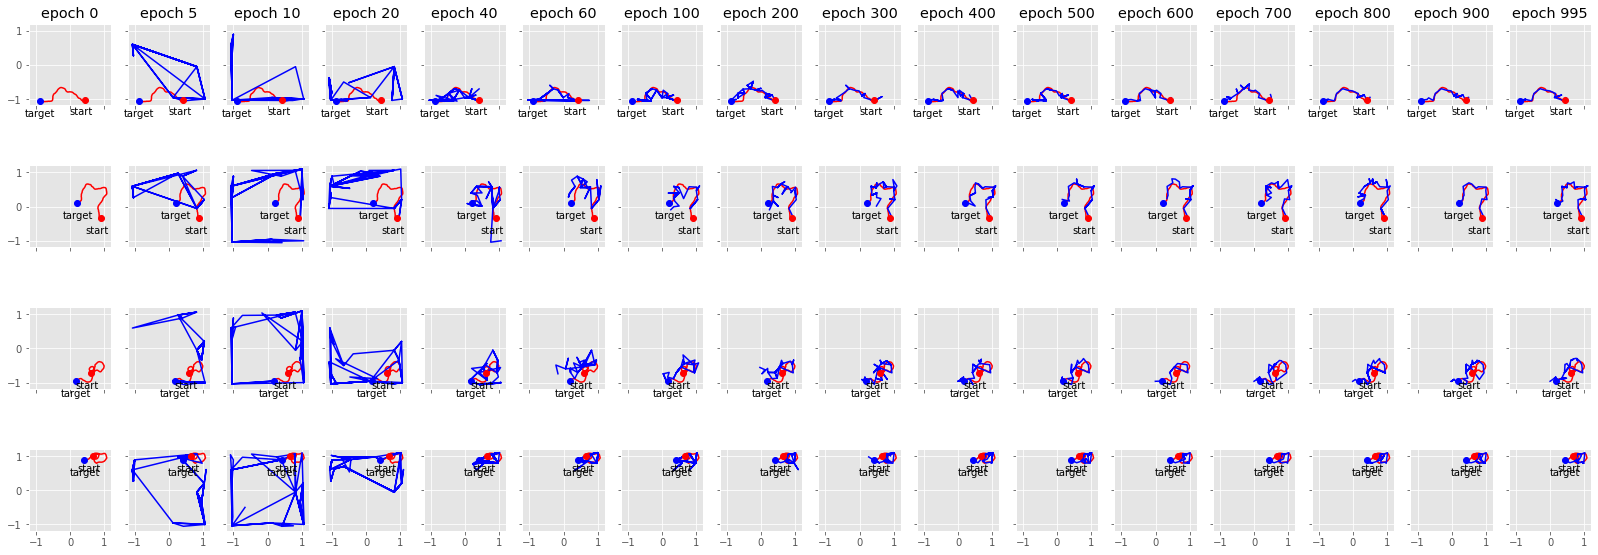

In [57]:
plot_traces(base_traces, model_nos)

# Error Ambulation

In [44]:
base_err = load_stats('results/stats', base_runs, 'err_amb_means')
nm_err = load_stats('results/stats', nm_runs, 'err_amb_means')
nm_dp_err = load_stats('results/stats', nm_dp_runs, 'err_amb_means')
nm_dp_lr_err = load_stats('results/stats', nm_dp_lr_runs, 'err_amb_means')

In [49]:
plt.figure(figsize=(10,12))
start=100
plt.plot(x[start:], base_err.mean(axis=0)[start:], '-', label='base model')
plt.fill_between(x[start:], base_err.min(axis=0)[start:], base_err.max(axis=0)[start:], label='base model', alpha=0.2)
plt.plot(x[start:], nm_err.mean(axis=0)[start:], '-', label='nm model')
plt.fill_between(x[start:], nm_err.min(axis=0)[start:], nm_err.max(axis=0)[start:], label='nm model', alpha=0.2)
plt.plot(x[start:], nm_dp_err.mean(axis=0)[start:], '-', label='nm dp model')
plt.fill_between(x[start:], nm_dp_err.min(axis=0)[start:], nm_dp_err.max(axis=0)[start:], label='nm dp model', alpha=0.2)
plt.plot(x[start:], nm_dp_lr_err.mean(axis=0)[start:], '-', label='nm dp lr model')
plt.fill_between(x[start:], nm_dp_lr_err.min(axis=0)[start:], nm_dp_lr_err.max(axis=0)[start:], label='nm dp lr model', alpha=0.2)
plt.legend()
plt.show()